In [1]:
!pip install patchify

In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [3]:
minmaxscaler = MinMaxScaler()

In [4]:
dataset_root_folder ='/content/drive/MyDrive/'

In [5]:
dataset_name = "Semanticsegmentationdataset"

In [6]:
image_patch_size = 256

In [7]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)

In [8]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [9]:
print(len(image_dataset))
print(len(mask_dataset))

216
216


In [10]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [11]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [12]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [13]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [14]:
total_classes = len(np.unique(labels))

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [17]:
master_trianing_dataset = image_dataset

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)


In [20]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [21]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 972.3 kB/s eta 0:00:00


In [22]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [23]:
from keras import backend as K

In [24]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [25]:
def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [26]:
metrics = ["accuracy", jaccard_coef]

In [27]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [28]:
model = get_deep_learning_model()

In [29]:
model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'registered_name': None,
   'name': 'input_1',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'HeNormal',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer': N

In [30]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [31]:
!pip uninstall keras efficientnet

Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? y
  Successfully uninstalled keras-2.15.0
Found existing installation: efficientnet 1.0.0
Uninstalling efficientnet-1.0.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/efficientnet-1.0.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/efficientnet/*
Proceed (Y/n)? y
  Successfully uninstalled efficientnet-1.0.0


In [32]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.2 MB/s eta 0:00:00


In [33]:
pip install segmentation-models

  Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)


In [34]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [35]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.2 MB/s eta 0:00:00


In [36]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import segmentation_models as sm
from tensorflow_addons.layers import AdaptiveAveragePooling2D

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [37]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [38]:
import tensorflow as tf

In [39]:
tf.keras.backend.clear_session()
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [41]:
from keras.callbacks import EarlyStopping

In [42]:

model_history = model.fit(X_train, y_train,
                          batch_size=32,  # Increase batch size to reduce memory usage
                          verbose=1,
                          epochs=150,
                          validation_data=(X_test, y_test),
                          shuffle=False)  # Add early stopping and memory callbacks


Epoch 1/150
6/6 [==============================] - 194s 26s/step - loss: 1.0121 - accuracy: 0.3803 - jaccard_coef: 0.1611 - val_loss: 1.0077 - val_accuracy: 0.3878 - val_jaccard_coef: 0.1503
Epoch 2/150
6/6 [==============================] - 150s 25s/step - loss: 1.0047 - accuracy: 0.4218 - jaccard_coef: 0.1965 - val_loss: 1.0049 - val_accuracy: 0.3894 - val_jaccard_coef: 0.1614
Epoch 3/150
6/6 [==============================] - 159s 27s/step - loss: 1.0025 - accuracy: 0.4255 - jaccard_coef: 0.1919 - val_loss: 1.0032 - val_accuracy: 0.3932 - val_jaccard_coef: 0.1782
Epoch 4/150
6/6 [==============================] - 152s 25s/step - loss: 1.0008 - accuracy: 0.4470 - jaccard_coef: 0.2077 - val_loss: 1.0026 - val_accuracy: 0.4230 - val_jaccard_coef: 0.1775
Epoch 5/150
6/6 [==============================] - 151s 25s/step - loss: 0.9995 - accuracy: 0.4726 - jaccard_coef: 0.2090 - val_loss: 1.0015 - val_accuracy: 0.4447 - val_jaccard_coef: 0.1894
Epoch 6/150
6/6 [============================

In [1]:
history_a = model_history

NameError: name 'model_history' is not defined

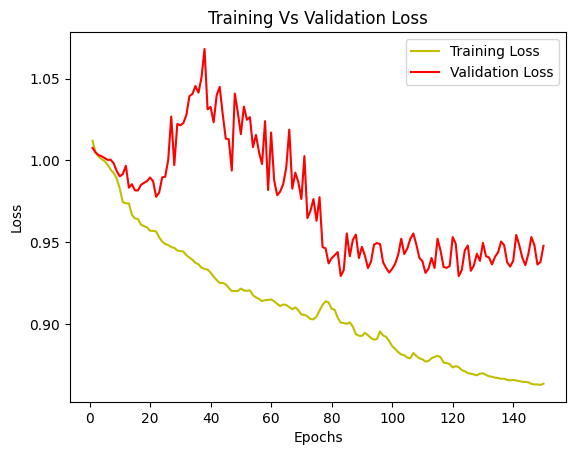

In [44]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

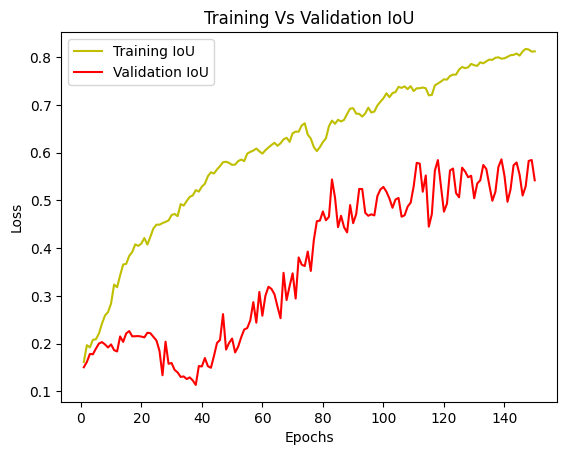

In [45]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [46]:
model_history.params

{'verbose': 1, 'epochs': 150, 'steps': 6}

In [47]:
y_pred = model.predict(X_test)

2/2 [==============================] - 5s 236ms/step


In [48]:
len(y_pred)

33

In [49]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [50]:
len(y_pred_argmax)

33

In [51]:
y_test_argmax = np.argmax(y_test, axis=3)

In [52]:
y_test_argmax

array([[[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 1, 2, 2],
        [3, 3, 3, ..., 1, 2, 2],
        [3, 3, 3, ..., 2, 2, 2]],

       [[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       ...,

       [[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 3, 3, 3],
        [0, 0, 0, ..., 3, 3, 3],
        [0, 0, 0, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 

In [53]:
import random

In [54]:
test_image_number = random.randint(0, len(X_test))
test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]
test_image_input = np.expand_dims(test_image, 0)
prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 290ms/step


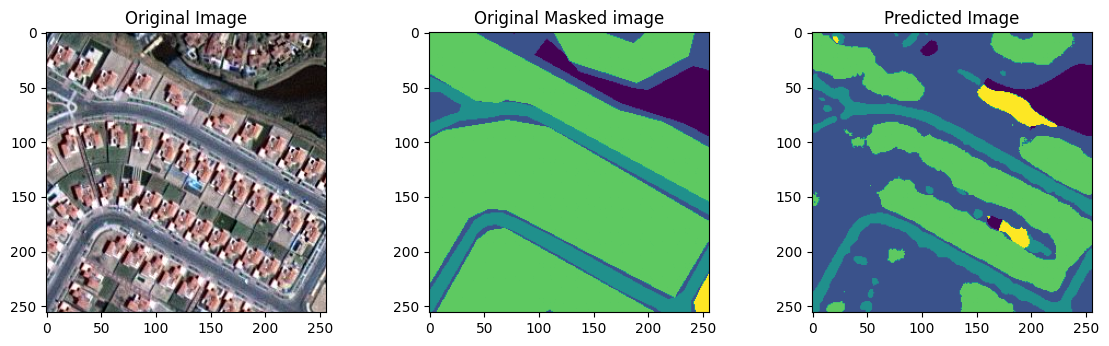

In [55]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [56]:
model.save("satellite_segmentation_full.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
